How to estimate noise in High-Frequency radar radial measurements
===================

This tutuorial shows how to estimate noise from High-Freuency data. It reproduces the calculations and figures of the paper:

* Jordi Isern-Fontanet, Lucía Quirós-Collazos, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2025). **Data-Driven Noise Estimation for Individual High-Frequency Radar Stations**. Submitted to *J. Atmos. Oceanic Technol.*

This turtorial uses the dataset:

* Lucía Quirós-Collazos, Jordi Isern-Fontanet, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2025). **Radial velocities for noise estimation of ICATMAR HF radar stations (v1.0)** https://doi.org/10.20350/digitalCSIC/17704

In [1]:
# System modules

import os
import glob
import sys

# Import scientific modules

import numpy as np
import xarray as xr

# Graphical packages

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS

# Each time a module is modified it is releaded

%load_ext autoreload
%autoreload 2

# Inline ploting

%matplotlib inline

# Parameters

Set the parameters necessary to run the notebook. Download the data set from https://doi.org/10.20350/digitalCSIC/17704 and modify `datapath` accordingly.

In [2]:
datapath = '/Users/jisern/Recerca/Data/Radar/L2B/'

Graphical information and objects

In [3]:
# Default color cycle

refcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Land mask for maps

land = NaturalEarthFeature(category='physical',
                           name='land',
                           scale='10m',
                           facecolor=COLORS['land'])
# Ocean mask for maps

ocean = NaturalEarthFeature(category='physical',
                            name='ocean',
                            scale='10m',
                            facecolor=COLORS['water'])

# Load and prepare the data

Load the data

In [4]:
hfrdata = {}              # Radar data

print('Loading data:')

for file in glob.glob(datapath + 'RDLm_????_*l2b.nc'):

    # Get the station name

    print('--', file)

    # Read the data

    ds = xr.open_dataset(file, engine="netcdf4")

    # Get information about the stations

    site = ds.attrs['Site'][:4]

    res = ds.attrs['Origin'].split(' ')
    lat0 = float(res[0])
    lon0 = float(res[-1])
    
    # Input files only has lat/lon when there were measurents. Extract all possible lat/lon. Data
    # gaps contain nan

    lon = ds['lon'].mean(dim='time')
    lat = ds['lat'].mean(dim='time')

    # Remove unnecessary variables and those that will be modifued (lat/lon)

    ds = ds.drop_vars(['lon', 'lat'])

    # Substitute lat/lon in the dataset by the new values

    ds.coords['lon'] = lon
    ds.coords['lat'] = lat

    # Number of observations at each range/bearing using the Primary Flag ('PRIM').

    count = xr.zeros_like(ds['PRIM'], dtype=int)
    count.data[ds['PRIM'].data == 1] = 1
    ds['nobs'] = count
    ds['nobs'].attrs["long_name"] = 'Number of observations'

    # Update attributes

    ds.attrs['Input_file'] = file
    ds.attrs['Site'] = site
    ds.attrs['lon0'] = lon0
    ds.attrs['lat0'] = lat0
    
    # Save the data

    hfrdata.update({site:ds})
    
print('Done')

Loading data:
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_PBCN_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_AREN_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_GNST_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_CREU_20230501_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_BEGU_20230401_20250529_l2b.nc
Done


Sort sites starting from the northrenmost one

In [5]:
hfrsites = []           # List of available sites sorted from North to south

# Extract the location of the station

dummy = []
for site in hfrdata.keys():
    dummy.append(hfrdata[site].attrs['lat0'])
    hfrsites.append(site)

# Convert to numpy arrays and sort

index = np.argsort(dummy)[::-1]
hfrsites = np.array(hfrsites)[index]

Assign colors to each site

In [6]:
hfrcolors = {}           # Colors for each HFR station

for i, site in enumerate(hfrsites):
    hfrcolors.update({site: refcolors[i]})

# Estimate noise

In [7]:
#ds2 = ds.resample(time='1D').mean()
#ds2

In [8]:
#for t, ds2 in ds.resample(time='1D'):
#    print(ds2.time.data)

# Figures

Plot the general characteristics of the data

CREU -4.694212 20.580917
BEGU -1.3767179 21.804422
AREN -3.2348714 14.986707
PBCN -3.0926156 16.857546
GNST -2.992226 19.04245


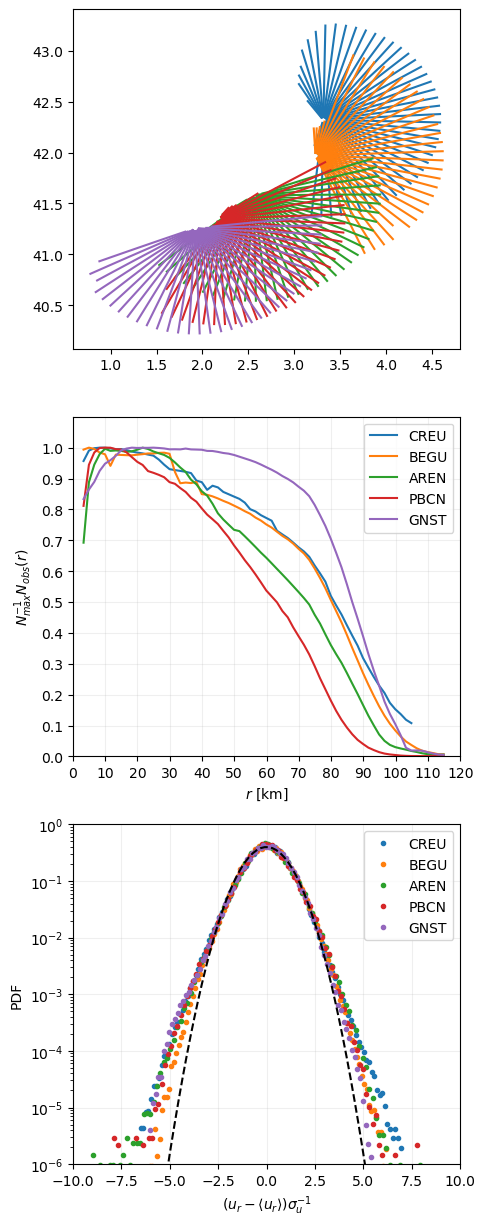

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

for site in hfrsites:

    # Get the data
    
    nr = hfrdata[site].sizes['range']
    nb = hfrdata[site].sizes['bearing']

    ur = hfrdata[site].VELO.data
    flag = hfrdata[site].PRIM.data
    range = hfrdata[site].range.data
    lon = hfrdata[site].lon.data
    lat = hfrdata[site].lat.data
    #nobs = hfrdata[site].nobs.data
    nobs = hfrdata[site].nobs.sum(dim='time').astype(int)

    # Fill the map
    
    for i in np.arange(nb):
        index = nobs[:, i] > 1
        ax[0].plot(lon[index, i], lat[index, i], color=hfrcolors[site], label=site)

    # Fill the data distribution

    n = np.sum(nobs, axis=-1)
    ax[1].plot(range, n / np.max(n), color=hfrcolors[site], label=site)

    # Fill velocity PDFs

    index = flag == 1
    aux = (ur[index] - np.mean(ur[index])) / np.std(ur[index])
    pdf, x = np.histogram(aux, density=True, bins=100)
    x = (np.roll(x, -1) + x)[:-1] / 2
    ax[2].semilogy(x, pdf, '.', color=hfrcolors[site], label=site)

    print(site, np.mean(ur[index]), np.std(ur[index]))

# Properties of the n(r) plot

a = ax[1]
a.set_xlabel('$r$ [km]')
a.grid(True, alpha=0.2)
a.set_xticks(np.linspace(0, 120, num=13))
a.set_xlim(0, 120)
a.legend()
a.set_ylabel('$N_{max}^{-1}N_{obs}(r)$')
a.set_yticks(np.linspace(0, 1, num=11))
a.set_ylim(0, 1.1)

# Velocity PDF

a = ax[2]
x = np.linspace(-10, 10, num=100)
y = np.exp(- x ** 2 / 2) / np.sqrt(2 * np.pi)
a.plot(x, y, 'k--')
a.set_xlabel('$(u_r-\\langle u_r\\rangle)\\sigma_u^{-1}$')
a.set_xlim(-10, 10)
a.grid(True, alpha=0.2)
a.legend()
a.set_ylabel('PDF')
a.set_ylim(1e-6, 1);

In [10]:
#np.histogram?